<a href="https://colab.research.google.com/github/ErrQD0303/MachineLearning/blob/main/GAT_geometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch-geometric==2.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.6 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]

In [ ]:
# 1. Import thư viện
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout

In [ ]:
# 2. Định nghĩa hàm accuracy()
def accuracy(y_pred, y_true):
  return torch.sum(y_pred == y_true) / len(y_true)

In [ ]:
# 3. Định nghĩa class GAT đại diện cho mô hình GAT
class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

  # Định nghĩa hàm tiến có sử dụng eLU và chuẩn hóa softmax
  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  # Định nghĩa hàm fit để huấn luyện mô hình
  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)
    self.train()
    for epoch in range(epochs+1):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if(epoch % 20 == 0):
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

  # Định nghĩa hàm đánh giá test
  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
# 3. Tiến hành train
gat = GAT(dataset.num_features, 32, dataset.num_classes)
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.962 | Train Acc: 14.29% | Val Loss: 1.96 | Val Acc: 14.00%
Epoch  20 | Train Loss: 0.210 | Train Acc: 96.43% | Val Loss: 0.92 | Val Acc: 72.40%
Epoch  40 | Train Loss: 0.217 | Train Acc: 97.14% | Val Loss: 0.91 | Val Acc: 73.40%
Epoch  60 | Train Loss: 0.177 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 72.00%
Epoch  80 | Train Loss: 0.193 | Train Acc: 97.86% | Val Loss: 0.99 | Val Acc: 71.40%
Epoch 100 | Train Loss: 0.206 | Train Acc: 97.14% | Val Loss: 0.91 | Val Acc: 72.00%


In [ ]:
# Đánh giá dữ liệu sử dụng mô hình đã được train
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 81.50%


Sử dụng GAT với CiteSeer|

# 1. First, we load the CiteSeer dataset:

In [20]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

2. For good measure, we plot the number of nodes per node degree, using the code from the
last chapter:

<BarContainer object of 32 artists>

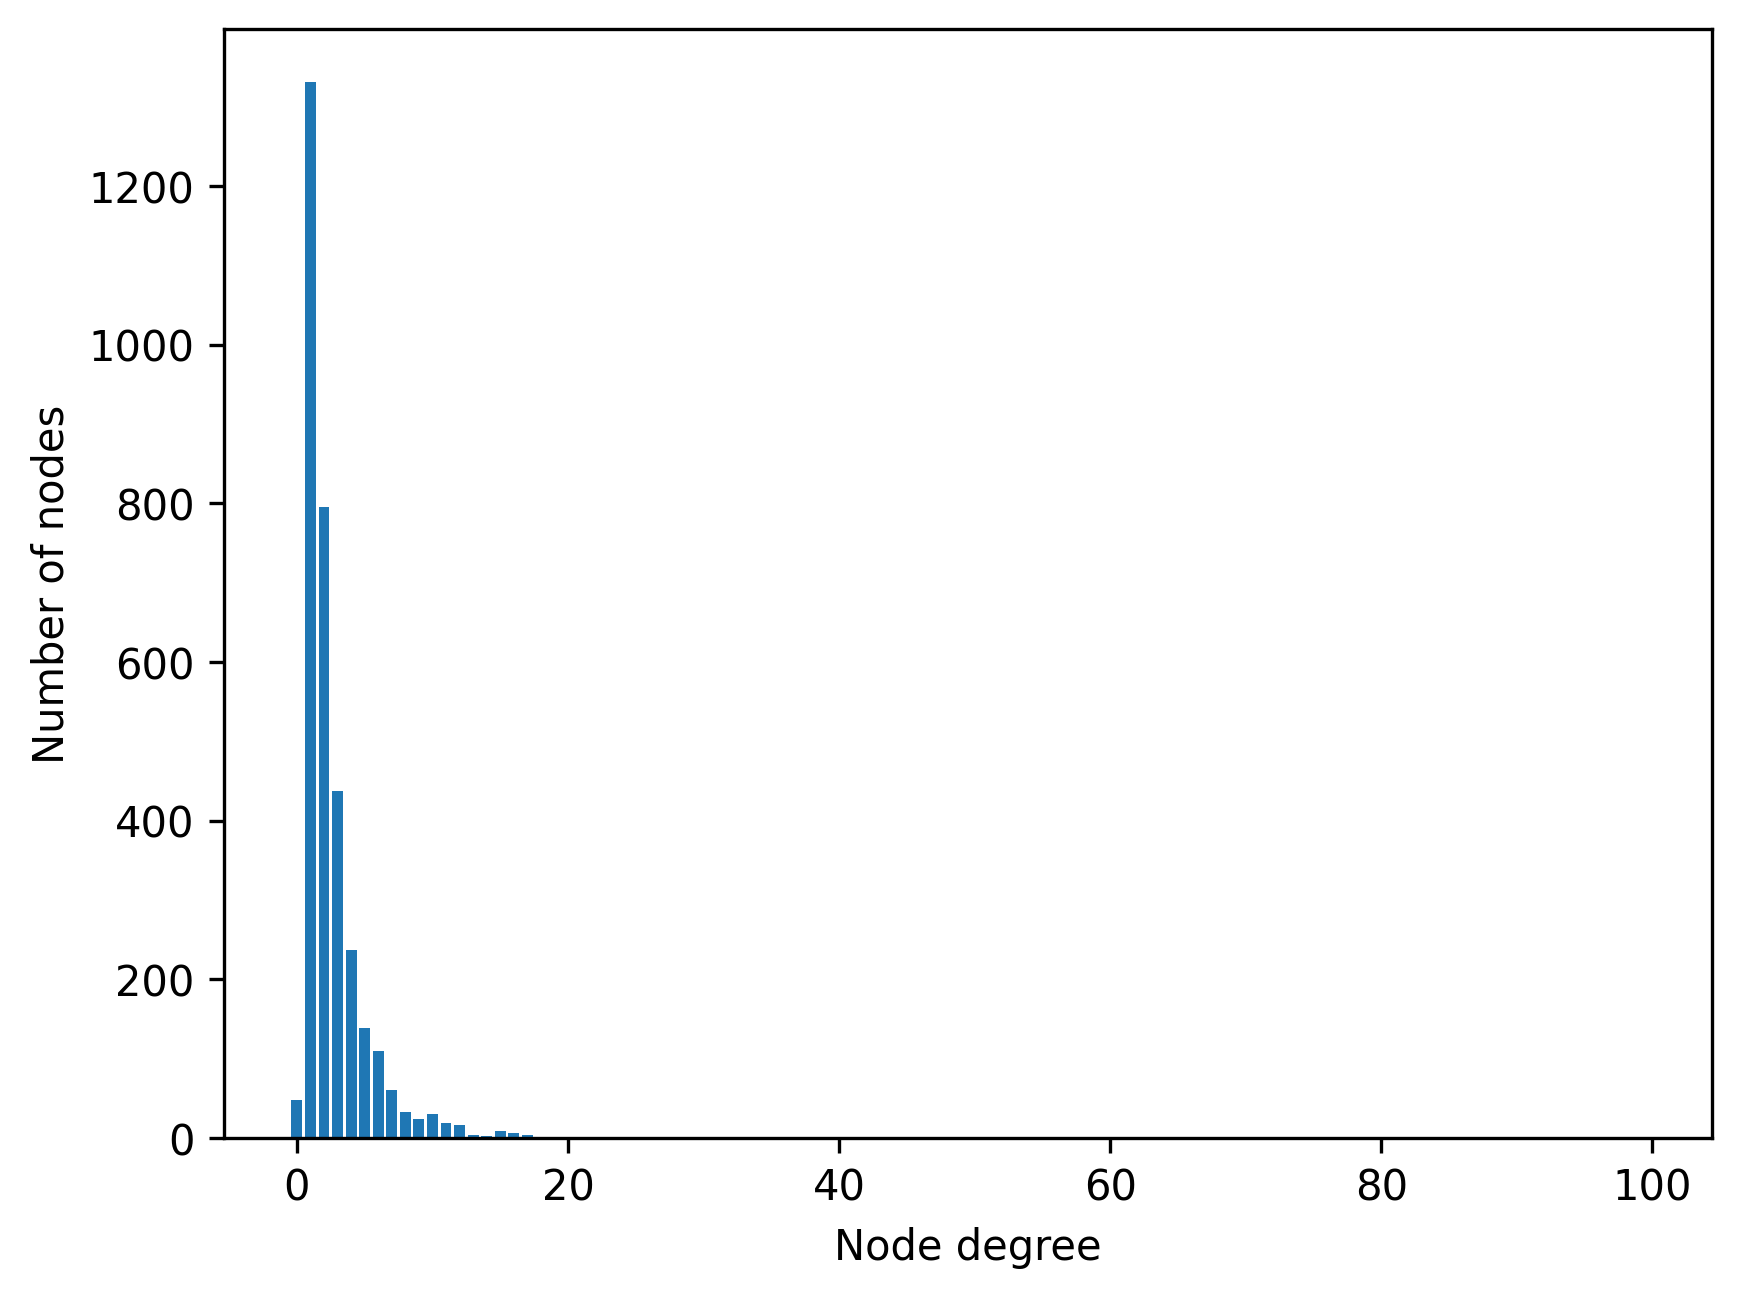

In [21]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter
degrees = degree(dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees)
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

looks like a typical heavy-tailed distribution but with a twist: some nodes have a degree of zero! In other words, they are not connected to any other node. We can assume that they will be much more difficult to classify than the rest.

We initialize a new GAT model with the correct number of input and output nodes and train it for 100 epochs:

In [22]:
gat = GAT(dataset.num_features, 16, dataset.num_classes)
gat.fit(data, epochs=100)

Epoch   0 | Train Loss: 1.806 | Train Acc: 10.83% | Val Loss: 1.78 | Val Acc: 22.60%
Epoch  20 | Train Loss: 0.164 | Train Acc: 96.67% | Val Loss: 1.05 | Val Acc: 65.40%
Epoch  40 | Train Loss: 0.123 | Train Acc: 99.17% | Val Loss: 1.18 | Val Acc: 62.60%
Epoch  60 | Train Loss: 0.127 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 62.60%
Epoch  80 | Train Loss: 0.120 | Train Acc: 99.17% | Val Loss: 1.24 | Val Acc: 61.80%
Epoch 100 | Train Loss: 0.122 | Train Acc: 98.33% | Val Loss: 1.21 | Val Acc: 60.20%


We obtain the following test accuracy score:

In [23]:
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 67.00%


According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better tha the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ± 0.9%). The authors also note that the accuracy scores are not normally distributed, making the usage of standard deviation less relevant. It is important to keep that in mind in this type of benchmark.

Previously, I speculated that poorly connected nodes might negatively impact performance. We can verify this hypothesis by plotting the average accuracy score for each node degree:

1. We get the model’s classilcations:

In [24]:
out = gat(data.x, data.edge_index)

2. We calculate the degree of each node:

In [25]:
degrees = degree(data.edge_index[0]).numpy()

We store the accuracy scores and sample sizes:

In [26]:
accuracies = []
sizes = []

We get the average accuracy for each node degree between zero and lve using a mask with np.where():

In [28]:
import numpy as np

for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

We repeat this process for every node with a degree higher than five:

In [29]:
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask],
data.y[mask]))
sizes.append(len(mask))

We plot these accuracy scores with the corresponding node degrees:

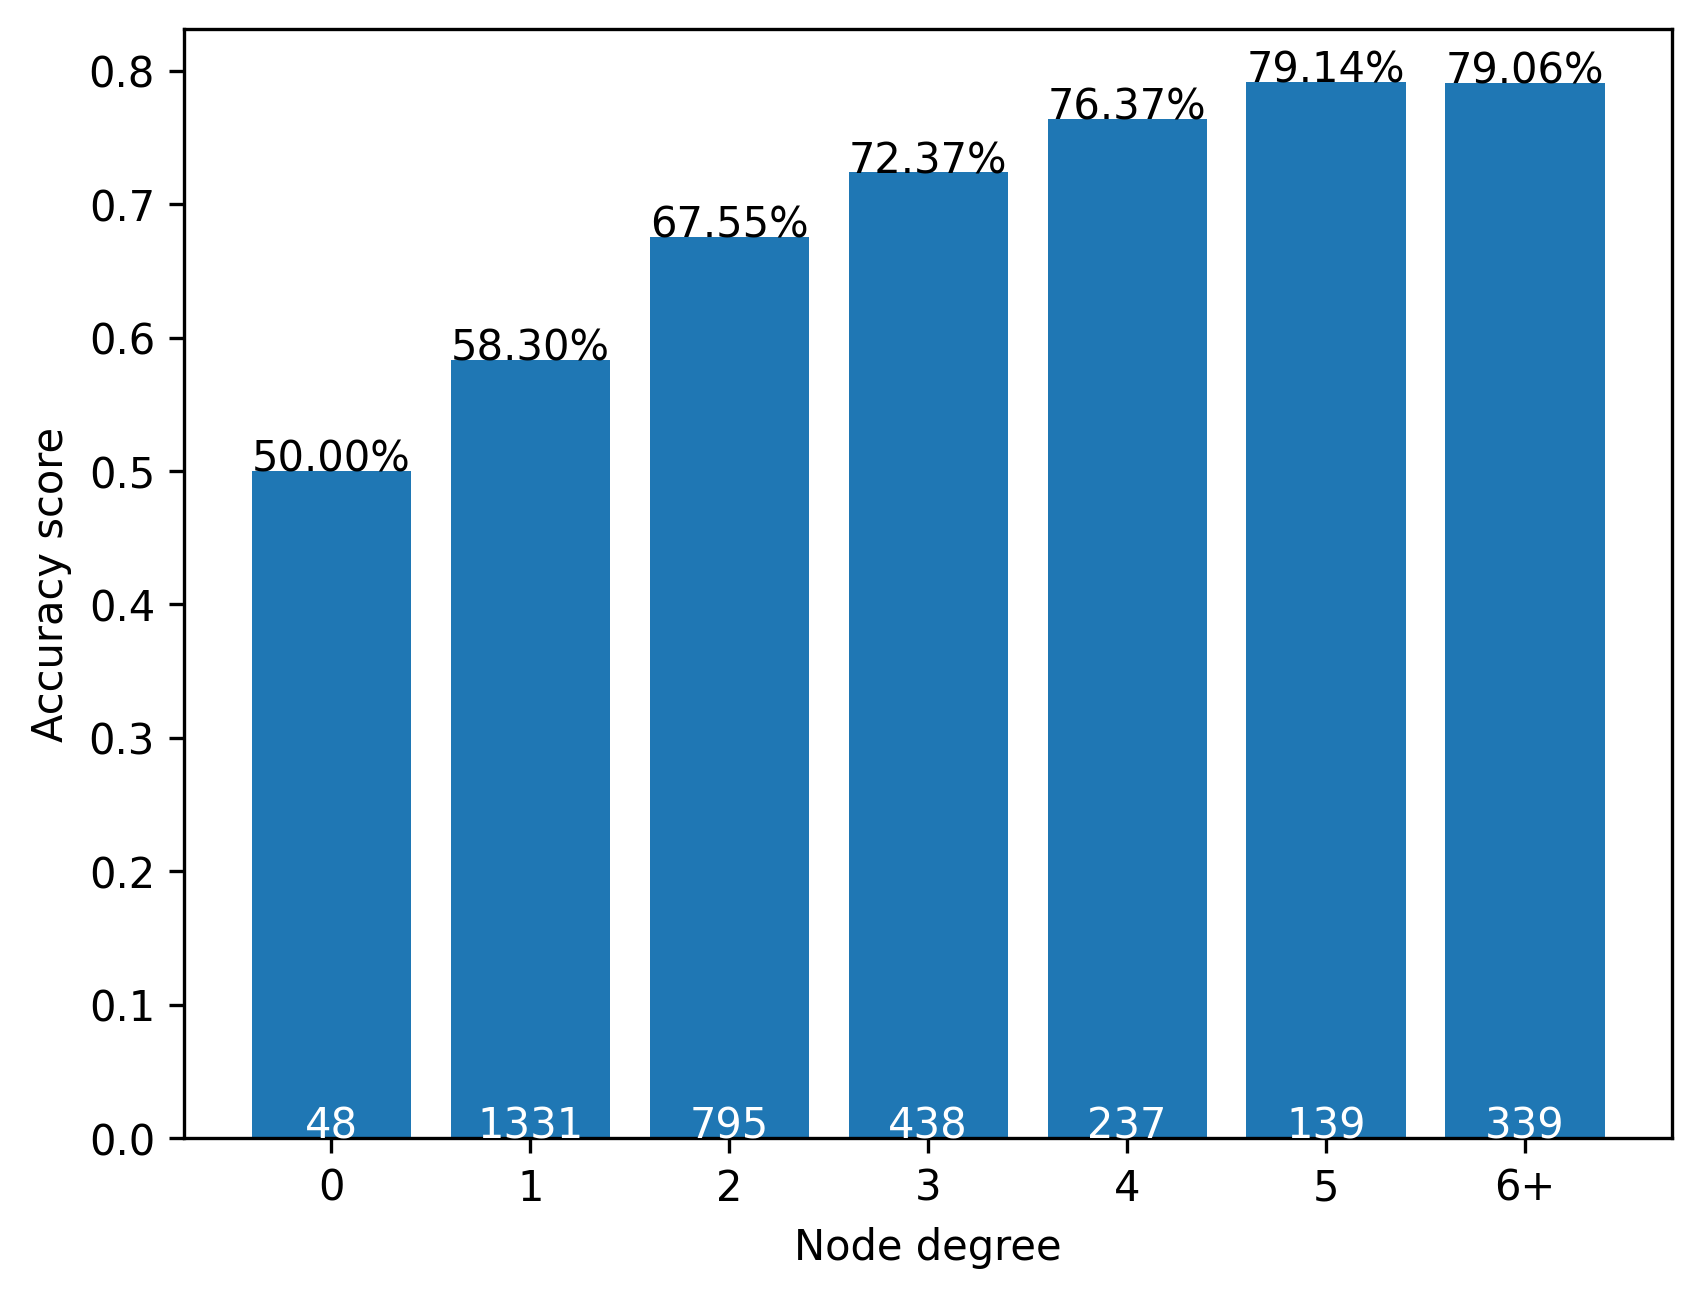

In [30]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
  plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
  plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

onlrms our hypothesis: nodes with few neighbors are harder to classify correctly. Furthermore, it even shows that, in general, the higher the node degree, the better the accuracy score. This is quite natural because a higher number of neighbors will provide more information to the GNN to make its predictions.